# Data Extraction and Data Formatting Notebook

This notebook shows how to preprocess the sample raw data files. For the LFP preprocessing consists of decimation, a 2 Hz highpass filter, and Hilbert transform. Your particular steps might (and likely will) differ and be specific to your data.

Data: Brian Lustig's raw rec01_BehavElectrDataLFP.mat file (for spikes and behavior) and rec01.lfp file (for LFP), which can be downloaded from https://figshare.com/authors/Seiji_Akera/16387584

## Supporting Functions

Defined here are supporting functions that extract behavioral, LFP, and spiking information for a session.

In [1]:
from scipy.signal import decimate
import numpy as np
import math
import os
from scipy import io
import matplotlib.pyplot as plt


def compAnly(Track, fs):
    """
    Input:
    Track = Contains information on the session pertaining to the track
    fs = sampling frequency

    Output:
    lapID = Data stored in the format listed below

    lapID format:
    Column 0: Trial Number
    Column 1: Maze arm (1/2/3)
    Column 2: Correct (0/1)
    Column 3: other/first approach/port/last departure (0/1/2/3)
    Column 4: position in mm
    """

    dec = 1250//fs #decimation factor

    lapID = np.array([ np.squeeze(Track["lapID"][0][0])[::dec] ])
    lapID = np.append(lapID, [ np.squeeze(Track["mazeSect"][0][0])[::dec] ], axis = 0)
    lapID = np.append(lapID, [ np.squeeze(Track["corrChoice"][0][0])[::dec] ], axis = 0)
    lapID = np.append(lapID, np.zeros((1, len(lapID[0]))), axis = 0)
    lapID = np.append(lapID, decimate(Track["xMM"][0][0].T,dec), axis =0)
    lapID = lapID.T

    # Filter values and construct column 3
    lapID[np.in1d(lapID[:,1], np.array(range(4, 10)), invert = True), 1] = 0
    lapID[lapID[:, 1] > 6, 3] = 2
    lapID[lapID[:, 1] > 0, 1] = (lapID[lapID[:,1] > 0, 1] - 1) % 3 + 1
    lapID[lapID[:, 1] == 0, :] = 0

    # Identify samples corresponding to the first period when the animal enters the maze section
    for i in range(1, int(np.max(lapID[:, 0]) + 1)):
        r = np.logical_and(lapID[:, 0] == i, lapID[:, 3] == 2)
        inds = np.where(lapID[:, 0] == i)[0]
        lapID[inds[inds < np.where(r > 0)[0][0]], 3] = 1
        lapID[inds[inds > np.where(r > 0)[0][-1]], 3] = 3

    # Return structured data
    return lapID

def get_spikes(mat_File,fs):
    """
    Input:
    mat_file = metadata file of type .mat
    fs = sampling rate

    Output:
    sp = binned spikes
    """
    mat = io.loadmat(mat_file, variable_names = ['Spike', 'Clu','xml'])
    n_channels = mat['xml']['nChannels'][0][0][0][0]
    dec = 1250//fs
    max_spike_res = np.ceil(np.max(mat['Spike']['res'][0][0])/dec) + 1
    max_spike_clu = np.max(mat['Spike']['totclu'][0][0]) + 1# Precompute the bins
    bins_res = np.arange(max_spike_res)
    bins_clu = np.arange(max_spike_clu)
    spike_res = np.squeeze(mat['Spike']['res'][0][0]) // dec
    spike_clu = np.squeeze(mat['Spike']['totclu'][0][0]) - 1

    # Bin both dimensions using histogram2d.
    sp, _,_ = np.histogram2d(spike_res, spike_clu, bins = (bins_res, bins_clu) )
    sp = sp.astype(np.uint8)

    mask = mat['Clu']['shank'][0][0][0] <= math.ceil(n_channels / 8)
    sp = sp[:, mask]

    return sp

def get_LFP(lfp_file, n_channels, fs, trial_phase):
    """
    Input:
    lfp_file = raw lfp data file of type .lfp
    fs = sampling rate

    Output:
    X = formatted lfp data
    """

    dec = 1250//fs
    file_size = os.path.getsize(lfp_file)
    data_size = np.dtype('int16').itemsize
    total_elements = file_size // data_size
    n_samples = total_elements // n_channels

    # Clip the dimensions to ensure the appropriate number of electrodes. Use multiple [0]'s to access the desired data.
    if n_channels > 256:
        n_keep = 255
    else:
        n_keep = 8

    # Efficiently load and decimate the data
    #slice_data = np.memmap(lfp_file, dtype='int16', mode='r', shape=(n_samples, n_channels))
    #X = decimate(slice_data[:, :n_keep], dec, axis=0)
    final_length = np.sum(trial_phase) #math.ceil(n_samples / dec)
    X = np.zeros((final_length, n_keep), dtype=np.float32)

    # Process each channel individually and store in the pre-allocated array
    for channel in range(n_keep):#24, 32):
        # Load the channel data using memmap
        channel_data = np.memmap(lfp_file, dtype='int16', mode='r', shape=(n_samples, n_channels))[:, channel+24]
        # Decimate the channel data
        temp = decimate(channel_data, dec, axis=0)
        print(temp)
        print("trial_phase:")
        print(trial_phase)
        print("sum(trial_phase):")
        print(sum(trial_phase))
        print("temp[trial_phase]:")
        print(temp[trial_phase])
        X[:,channel] = temp[trial_phase]
        print(channel)

    return X

## Behavior importing

In [2]:
from scipy import io

fs = 625 #sampling rate in Hz
data_dir = "/Users/lukefeng/Desktop/LustigData/" #Replace this with your file location

# Specify data files
mat_file = data_dir + "rec01_BehavElectrDataLFP.mat" #contains spiking and behavioral data
lfp_file = data_dir + "rec01.lfp" #contains LFP data

# Extract behavior
mat = io.loadmat(mat_file, variable_names = ['Track'])#, 'Spike', 'Clu'])
lapID = compAnly(mat['Track'],fs)


## Visualize phases of trial

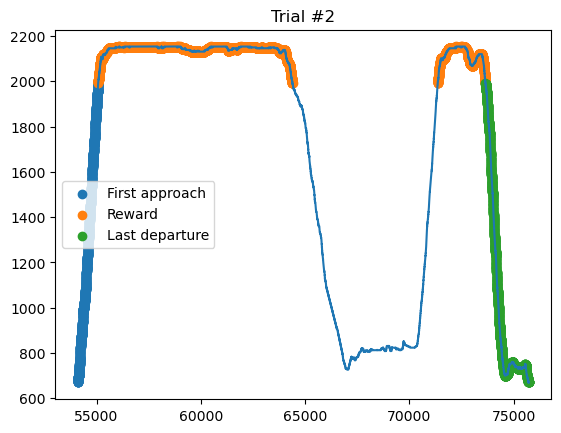

In [3]:
trNum = 2
inds = np.where(lapID[:,0] == trNum)[0]
plt.plot(inds,lapID[inds,4]);
lab = ['First approach','Reward','Last departure']
for i in range(1,4):
    inds = np.where(np.logical_and(lapID[:,0] == trNum, lapID[:,3] == i))[0]
    plt.scatter(inds,lapID[inds,4],label=lab[i-1]);

plt.legend();
plt.title('Trial #' + str(trNum));

## LFP importing

In [4]:
mat = io.loadmat(mat_file, variable_names = ['xml'])
n_channels = mat['xml']['nChannels'][0][0][0][0]
X = get_LFP(lfp_file,n_channels,fs,lapID[:,3]==2)

[3851.63997168 3486.88963026 3650.71442651 ... 2913.91355092 3318.17876075
 2763.39008467]
trial_phase:
[False False False ... False False False]
sum(trial_phase):
961399
temp[trial_phase]:
[4103.77795617 4045.88124513 3928.43298454 ... 3838.14939687 3864.91216562
 3861.85364104]
0
[4323.36896577 3940.70300092 4087.67138427 ... 3315.22262481 3777.89695309
 3141.14879449]
trial_phase:
[False False False ... False False False]
sum(trial_phase):
961399
temp[trial_phase]:
[4602.69762967 4543.8030982  4439.41149432 ... 4314.96522186 4349.17545089
 4343.53967183]
1
[3726.50864125 3491.2715243  3679.56945589 ... 3402.98691849 3668.45978216
 3053.9297496 ]
trial_phase:
[False False False ... False False False]
sum(trial_phase):
961399
temp[trial_phase]:
[4068.75197987 3949.41954796 3778.10333153 ... 3893.4523168  3873.17863908
 3932.07751792]
2
[4085.96960023 3726.49560061 3893.27098302 ... 3191.45283076 3608.62421738
 3007.79326981]
trial_phase:
[False False False ... False False False]
sum(t

## Spike importing

In [ ]:
print(X)
np.save('neuro_data.npy', X)

[[4103.778  4602.6978 4068.752  ... 4604.9385 3909.3337 4336.1733]
 [4045.8813 4543.803  3949.4194 ... 4526.7114 3811.3706 4244.628 ]
 [3928.433  4439.4116 3778.1033 ... 4357.925  3638.3748 4110.643 ]
 ...
 [3838.1494 4314.9653 3893.4524 ... 4266.983  3934.2346 4417.561 ]
 [3864.912  4349.1753 3873.1787 ... 4232.7964 3913.5667 4387.751 ]
 [3861.8538 4343.5396 3932.0776 ... 4275.781  3965.9673 4455.84  ]]


In [ ]:
sp = get_spikes(mat_file,fs)